In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import sys
sys.path.append("..")

In [37]:
from platform import python_version
print(python_version())

3.6.8


In [38]:
import torch
from src.aggregator import *
from src.datagen.sinecurve import *
from src.datagen.gpcurve import *

## GP tester

- RBF
- Matern
- Additive
- Product

In [39]:
gpgen = RBFGPCurvesReader(16, 100)

In [40]:
a = gpgen.generate_curves()

In [41]:
import matplotlib.pyplot as plt

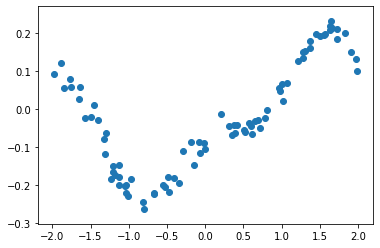

In [42]:
plt.scatter(a[0][0][0][0], a[0][0][1][0])

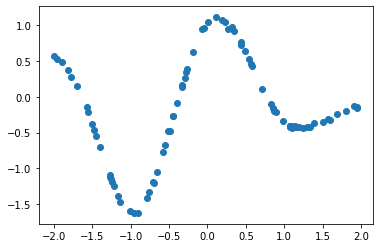

In [43]:
plt.scatter(a[0][0][0][1], a[0][0][1][1])

In [44]:
materngp = MaternGPCurvesReader(16,100)

In [45]:
a = gpgen.generate_curves()

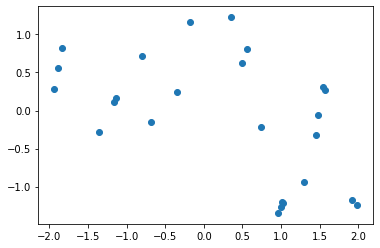

In [46]:
plt.scatter(a[0][0][0][0], a[0][0][1][0])

## Sine curve tester


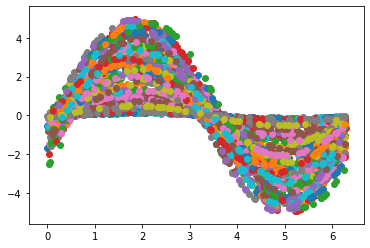

In [47]:
this = SineCurvesReader().generate_curves()
context_data_x, context_data_y = this.query[0]
context_data_x = context_data_x.squeeze()
context_data_y = context_data_y.squeeze()

context_data_x.shape
context_data_y.shape

for curve_id in range(context_data_x.shape[0]):
    plt.scatter(context_data_x[curve_id, :].tolist(), context_data_y[curve_id, :].tolist())

## Encoder

In [48]:
from src.decoder import *
from src.encoder import *
from src.utils import *

## Decoder

## Attentive Neural Process

In [49]:
from src.neural_process import *

## Training

In [50]:
TRAINING_ITERATIONS = 100000 #@param {type:"number"}
MAX_CONTEXT_POINTS = 50 #@param {type:"number"}
PLOT_AFTER = 10000 #@param {type:"number"}
HIDDEN_SIZE = 128 #@param {type:"number"}
ATTENTION_TYPE = 'uniform' #@param ['uniform','laplace','dot_product','multihead']
random_kernel_parameters=True #@param {type:"boolean"}

In [51]:
# Train dataset
dataset_train = RBFGPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = RBFGPCurvesReader(
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True, random_kernel_parameters=random_kernel_parameters)
data_test = dataset_test.generate_curves()



In [52]:
#query = ((context_x, context_y), target_x)

In [53]:
data_train.query[0][0].shape

torch.Size([16, 35, 1])

In [54]:
data_train.query[0][1].shape

torch.Size([16, 35, 1])

In [55]:
data_train.query[1][0].shape

torch.Size([40, 1])

In [56]:
data_train.target_y.shape

torch.Size([16, 40, 1])

In [57]:
# Sizes of the layers of the MLPs for the encoders and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
x_dim = 1
y_dim = 1
r_dim = 64
z_dim = 64
hid_dim = 128
num_hid = 3

In [58]:
detencoder = DeterministicEncoder(x_dim, y_dim, r_dim, hid_dim=hid_dim, num_hid=num_hid)
latencoder = LatentEncoder(x_dim, y_dim, z_dim, hid_dim=hid_dim, num_hid=num_hid)
decoder = HeteroskedasticDecoder(x_dim, r_dim + z_dim, y_dim, hid_dim=hid_dim, num_hid=2)
att = Attention('mlp','multihead', x_dim, r_dim, hid_dim=hid_dim, num_hid=num_hid)
anp = AttentiveNeuralProcess(detencoder, att, latencoder, decoder, True)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [59]:
anp

AttentiveNeuralProcess(
  (deterministic_encoder): DeterministicEncoder(
    (encoder): BatchMLP(
      (activation): ReLU()
      (model): Sequential(
        (0): Linear(in_features=2, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
      )
    )
  )
  (attention): Attention(
    (batch_mlp): BatchMLP(
      (activation): ReLU()
      (model): Sequential(
        (0): Linear(in_features=1, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=64, bias=True)
      )
    )
    (multihead_attention): MultiheadAttention(
      (out_proj): Li

In [60]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(anp.parameters(), lr=0.001)
EPOCHS = 500


In [61]:
from copy import deepcopy
base_parames = [p.data for p in anp.parameters()]
# base_parames

In [62]:
EPOCHS = 1000

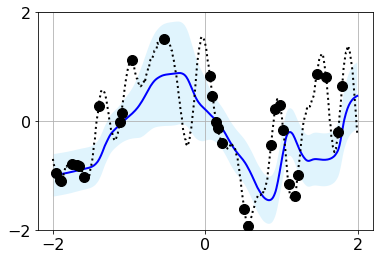

log_pred: -133.4290008544922, kl_target_context: 2.5557221761118853e-06, loss: 0.41696563363075256


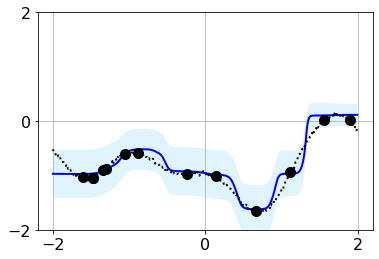

log_pred: 49.597679138183594, kl_target_context: 2.489809958206024e-06, loss: -0.12916062772274017


KeyboardInterrupt: 

In [63]:
from src.utils import plot_functions

for epoch in range(EPOCHS):
    epoch_loss = 0
    # Train dataset
    dataset_train = RBFGPCurvesReader(
    batch_size=16, max_num_context=MAX_CONTEXT_POINTS, random_kernel_parameters=random_kernel_parameters)
    data_train = dataset_train.generate_curves()
    x_context = data_train.query[0][0].contiguous()
    y_context = data_train.query[0][1].contiguous()
    x_target = data_train.query[1].contiguous()
    y_target = data_train.target_y.contiguous()
    optimizer.zero_grad()
    
    y_target_mu, y_target_sigma, log_pred, kl_target_context, loss = anp.forward(x_context, y_context, x_target, y_target)
    loss.backward()
    optimizer.step()
    
    if (epoch % 100) == 0:
        data_test = dataset_test.generate_curves()
        x_context = data_test.query[0][0].contiguous()
        y_context = data_test.query[0][1].contiguous()
        x_target = data_test.query[1].contiguous()
        y_target = data_test.target_y.contiguous()
        y_target_mu, y_target_sigma, _, _, _ = anp.forward(x_context, y_context, x_target, y_target)
#         plt.scatter(x_target[0].cpu(), y_target_mu[0].cpu().data)
#         plt.show()
#         plt.close()
#         plt.figure()
#         plt.scatter(x_context[0].cpu(), y_context[0].cpu())
#         plt.show()
#         plt.close()
        plot_functions(x_target, y_target, x_context, y_context, y_target_mu, y_target_sigma)
        print(f'log_pred: {log_pred.sum()}, kl_target_context: {kl_target_context.sum()}, loss: {loss.sum()}')

In [ ]:
batch_size, num_context_points, y_size = y_context.size()
_, num_target_points, _ = x_target.size()

# map the context points to their deterministic represnetations.
# r_i : Shape (batch_size, num_context_points, r_dim)
r_i = anp.deterministic_encoder(x_context, y_context)

In [ ]:
r_i.shape

In [ ]:
r_j = anp.attention(x_target, x_context, r_i)

In [ ]:
log_pred.shape

In [ ]:
kl_target_context.shape

In [ ]:
data_train.num_context_points

In [ ]:
x_context.shape

In [ ]:
data_train.num_total_points

In [ ]:
y_context.shape

In [ ]:
loss

In [ ]:
x_context[0].data

In [ ]:
plt.scatter(x_target[0], y_target_mu[0].data)
plt.scatter(x_context[0], y_context[0])

In [ ]:
plt.scatter(x_context[0], y_context[0])

In [ ]:
 y_context[0]